In [6]:
import numpy as np
from My_custom_Envs import HangedManEnv
import statsmodels
import random
max_length = 3

In [4]:
import numpy as np
import random

from collections import deque


In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [7]:

# Hyperparamètres du DQN
epsilon_decay = 0.9975
min_epsilon = 0.05
epsilon = 0.3
discount_factor = 1  # Gamma
learning_rate = 0.001
n_episode = 50000
batch_size = 64
memory_size = 10000


In [31]:

# Créer une mémoire pour le replay buffer
memory = deque(maxlen=memory_size)

# Modèle du réseau de neurones pour approximer la Q-table
def build_model(input_size, output_size):
    model = Sequential()
    model.add(Dense(128, input_dim=input_size, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(output_size, activation='linear'))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

# Initialiser le modèle
input_size = 1  # Taille de l'état
output_size = 26  # Taille des actions
model = build_model(input_size, output_size)


In [32]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,122 (78.60 KB)

 Trainable params: 20,122 (78.60 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Fonction epsilon-greedy modifiée pour DQN
def epsilon_greedy_policy(state, model, epsilon):
    if np.random.rand() < epsilon:
        # Exploration: choisir une action aléatoire
        active_actions = np.where((1 - state[1]))[0]
        return random.choice(active_actions)
    else:
        # Exploitation: utiliser le modèle pour choisir l'action avec la valeur Q maximale
        q_values = model.predict(state[0].reshape(1, -1))
        masked_q_values = np.copy(q_values[0])
        if sum(state[1]) > 0:
            masked_q_values[state[1]] = -np.inf
        return np.argmax(masked_q_values)

# Ajouter l'expérience dans la mémoire
def store_experience(memory, state, action, reward, next_state, terminated):
    memory.append((state, action, reward, next_state, terminated))


In [35]:
# Entraîner le modèle avec les échantillons du replay buffer
def replay(memory, batch_size, model):
    if len(memory) < batch_size:
        return

    mini_batch = random.sample(memory, batch_size)
    for state, action, reward, next_state, terminated in mini_batch:
        target = reward
        if not terminated:
            next_q_values = model.predict(next_state[0].reshape(1, -1))
            target = reward + discount_factor * np.amax(next_q_values[0])
        q_values = model.predict(state[0].reshape(1, -1))
        q_values[0][action] = target
        
        # Entraîner le modèle sur cet échantillon
        model.fit(state[0].reshape(1, -1), q_values, epochs=1, verbose=0)

# Variables pour suivre les récompenses par épisode
hist_reward = np.zeros(n_episode)
hist_actions = np.zeros((26, n_episode))


In [36]:

# Initialiser l'environnement
env = HangedManEnv(max_word_size=max_length)


In [38]:
# Boucle d'apprentissage DQN
for episode in range(n_episode):
    # Réinitialiser l'environnement
    obs, info = env.reset()
    terminated = False
    step = 1
    state = (obs[0], obs[1])  # Observation = (encoded word, letters tried)

    # Transformer l'état en une forme adaptée à l'entrée du réseau de neurones
    state_index = np.dot(obs[0], [28**i for i in range(max_length)])
    
    while not terminated:
        # Choisir l'action avec epsilon-greedy
        action = epsilon_greedy_policy((state_index, obs[1]), model, epsilon)

        # Jouer l'action et obtenir les récompenses et le nouvel état
        next_obs, reward, terminated, _, _ = env.step(action)
        next_state_index = np.dot(next_obs[0], [28**i for i in range(max_length)])

        # Sauvegarder l'expérience dans la mémoire
        store_experience(memory, (state_index, obs[1]), action, reward, (next_state_index, next_obs[1]), terminated)

        # Mettre à jour l'état
        state_index = next_state_index

        # Réduire epsilon pour diminuer l'exploration au fil des épisodes
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Entraîner le modèle avec la mémoire (replay buffer)
        replay(memory, batch_size, model)

        # Suivi des récompenses
        hist_reward[episode] += reward
        hist_actions[action, episode] = step
        step += 1

# Fermer l'environnement
env.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

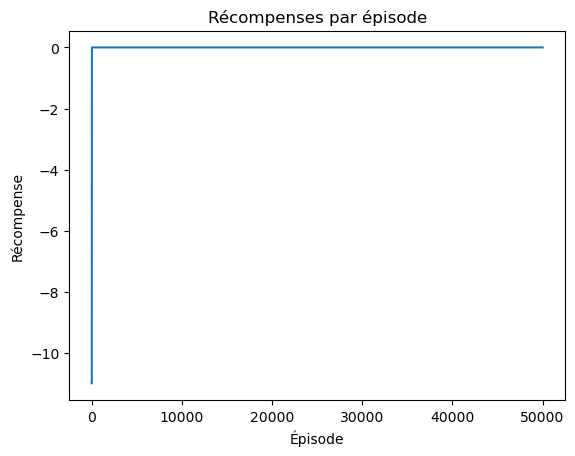

In [39]:
# Visualisation des résultats (exemple d'utilisation)
import matplotlib.pyplot as plt

# Graphique des récompenses par épisode
plt.plot(range(n_episode), hist_reward)
plt.title("Récompenses par épisode")
plt.xlabel("Épisode")
plt.ylabel("Récompense")
plt.show()


In [40]:
step

6